# Explainable AI

In [1]:
import os
import sys
sys.path.append('/Users/damienmellot/desktop/MLE/Projects/fml/call-option-pricing/')

import warnings
warnings.filterwarnings('ignore')

import src.settings.base as stg
from src.infrastructure.datageneration import CallData

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

import eli5
from pdpbox import pdp, get_dataset, info_plots
from pycebox.ice import ice, ice_plot
import treeinterpreter
import shap

In [2]:
cd = CallData()
df = cd.data
X = df[stg.FEATURES]
Y = df[stg.TARGET]

validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

In [3]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(5,5))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [4]:
rfr = RandomForestRegressor()
rfr = rfr.fit(X_train,Y_train)

## 1. eli5 (mlpr)

In [5]:
mlpr = MLPRegressor()
mlpr.fit(X_train,Y_train)
eli5.show_weights(rfr)

## 2.PDP (mlpr)

In [6]:
f_predict = lambda x: mlpr.predict(x)

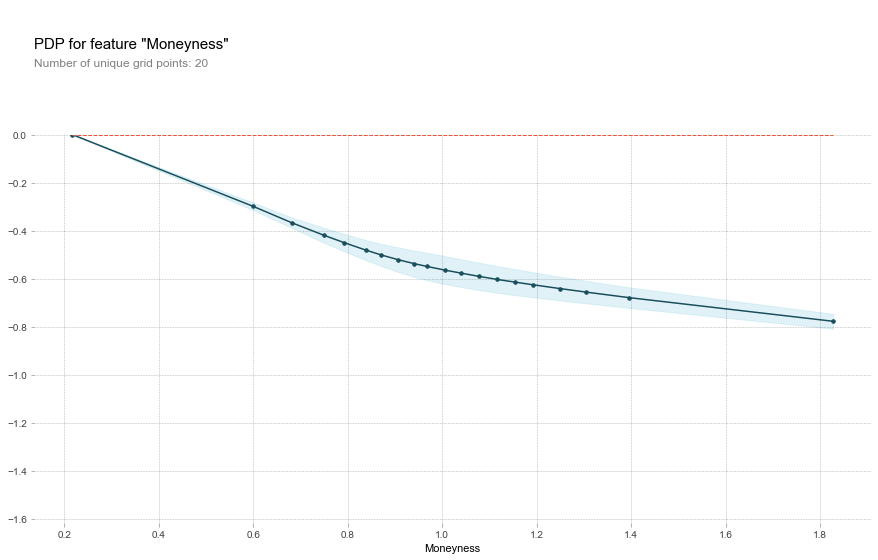

In [7]:
variable = stg.MONEYNESS

pdp_goals = pdp.pdp_isolate(model=mlpr,
                            dataset=X_test,
                            model_features=X_test.columns,
                            feature=variable,
                            num_grid_points=20,
                            grid_type='percentile', #possible values: 'equal' or 'percentile'
)

pdp.pdp_plot(pdp_goals, variable, center=True) # center arg center plots and compare each value to the first one
plt.show()

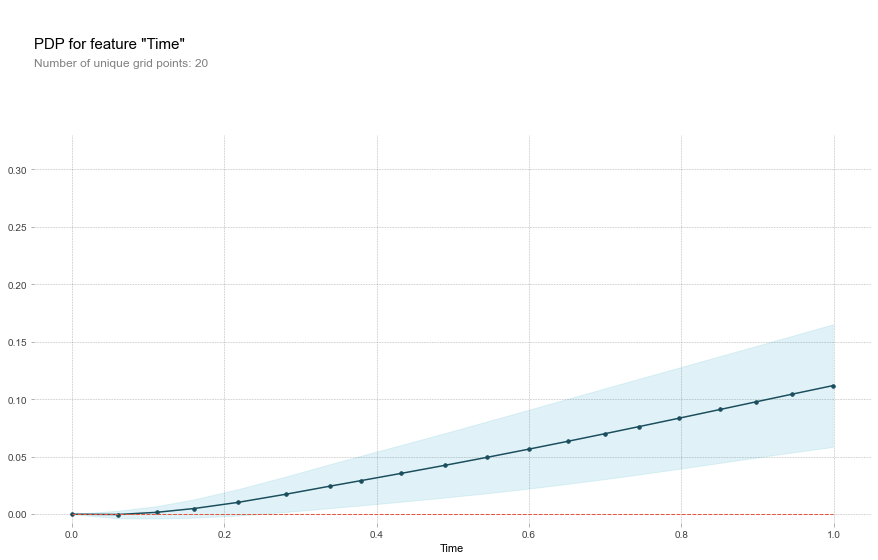

In [8]:
variable = stg.TIME

pdp_goals = pdp.pdp_isolate(model=mlpr,
                            dataset=X_test,
                            model_features=X_test.columns,
                            feature=variable,
                            num_grid_points=20,
                            grid_type='percentile', #possible values: 'equal' or 'percentile'
)

pdp.pdp_plot(pdp_goals, variable, center=True) # center arg center plots and compare each value to the first one
plt.show()

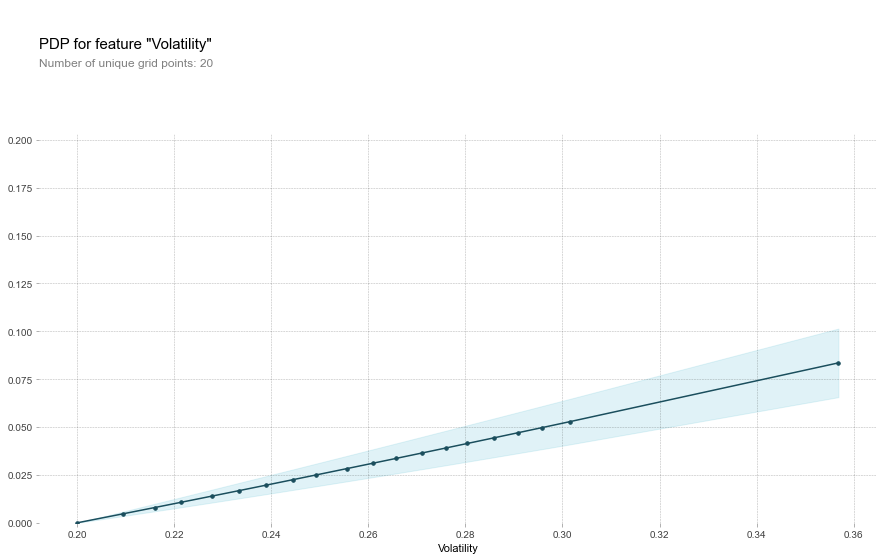

In [9]:
variable = stg.VOLATILITY

pdp_goals = pdp.pdp_isolate(model=mlpr,
                            dataset=X_test,
                            model_features=X_test.columns,
                            feature=variable,
                            num_grid_points=20,
                            grid_type='percentile', #possible values: 'equal' or 'percentile'
)

pdp.pdp_plot(pdp_goals, variable, center=True) # center arg center plots and compare each value to the first one
plt.show()

## 3. Pycebox (mlpr)

Text(0.5, 1.0, 'ICE Curves')

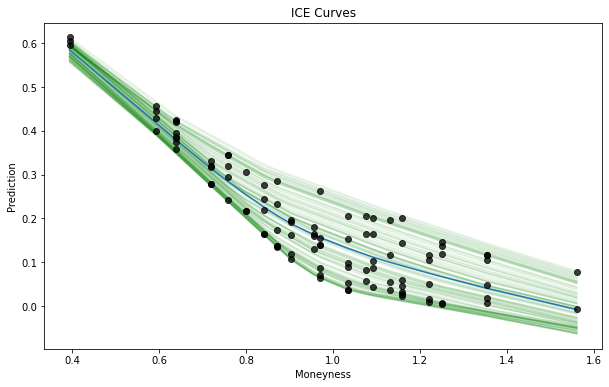

In [10]:
X_ref = X_test.copy().sample(100)
variable = stg.MONEYNESS

ice_df = ice(X_ref, variable, f_predict, num_grid_points=20)

fig, ax_ice = plt.subplots(nrows=1, ncols=1,figsize=(10, 6))

ice_plot(ice_df, plot_points=True, point_kwargs={'color': 'k', 'alpha': 0.75}, c='g',
         alpha=0.1, plot_pdp=True, ax=ax_ice)

ax_ice.set_xlabel(variable)
ax_ice.set_ylabel('Prediction') 
ax_ice.set_title('ICE Curves')

Text(0.5, 1.0, 'ICE Curves')

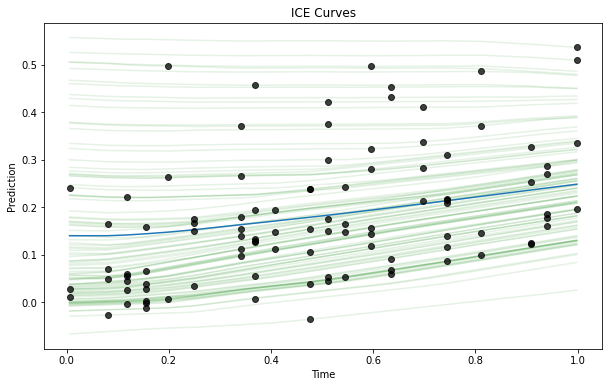

In [11]:
X_ref = X_test.copy().sample(100)
variable = stg.TIME

ice_df = ice(X_ref, variable, f_predict, num_grid_points=20)

fig, ax_ice = plt.subplots(nrows=1, ncols=1,figsize=(10, 6))

ice_plot(ice_df, plot_points=True, point_kwargs={'color': 'k', 'alpha': 0.75}, c='g',
         alpha=0.1, plot_pdp=True, ax=ax_ice)

ax_ice.set_xlabel(variable)
ax_ice.set_ylabel('Prediction') 
ax_ice.set_title('ICE Curves')

Text(0.5, 1.0, 'ICE Curves')

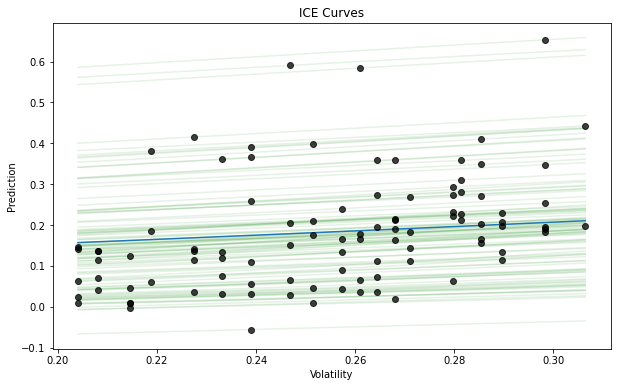

In [12]:
X_ref = X_test.copy().sample(100)
variable = stg.VOLATILITY

ice_df = ice(X_ref, variable, f_predict, num_grid_points=20)

fig, ax_ice = plt.subplots(nrows=1, ncols=1,figsize=(10, 6))

ice_plot(ice_df, plot_points=True, point_kwargs={'color': 'k', 'alpha': 0.75}, c='g',
         alpha=0.1, plot_pdp=True, ax=ax_ice)

ax_ice.set_xlabel(variable)
ax_ice.set_ylabel('Prediction') 
ax_ice.set_title('ICE Curves')

## 4. Scikit-learn features importance (rfr)

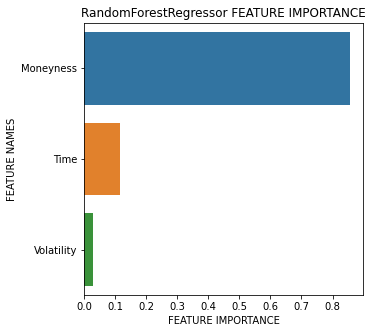

In [13]:
plot_feature_importance(rfr[1].feature_importances_,names=stg.FEATURES, model_type='RandomForestRegressor ')

## 5. Shap (rfr)

In [14]:
shap.initjs()
X_train_small = X_train.copy().sample(200)

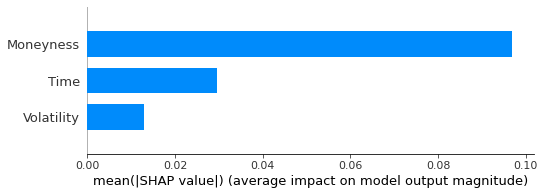

In [15]:
shap_values = shap.TreeExplainer(rfr).shap_values(X_train_small)
shap.summary_plot(shap_values, X_train_small, plot_type="bar")

In [16]:
X_ref_shap = X_test.copy()

In [17]:
%%time
explanation = shap.TreeExplainer(rfr)
shap_values = explanation.shap_values(X_ref_shap)
df_contrib = pd.DataFrame(shap_values, columns=X_ref_shap.columns, index=X_ref_shap.index)
bias = explanation.expected_value

CPU times: user 1min 24s, sys: 207 ms, total: 1min 25s
Wall time: 1min 25s


In [18]:
index = 2
shap.force_plot(explanation.expected_value, shap_values[index, :], X_ref_shap.iloc[index, :])

In [19]:
shap.force_plot(explanation.expected_value, shap_values, X_ref_shap)

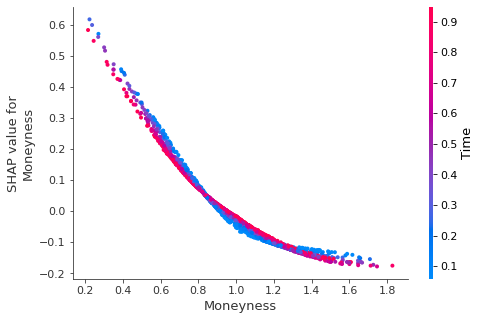

In [20]:
shap.dependence_plot(stg.MONEYNESS, shap_values, X_ref_shap)

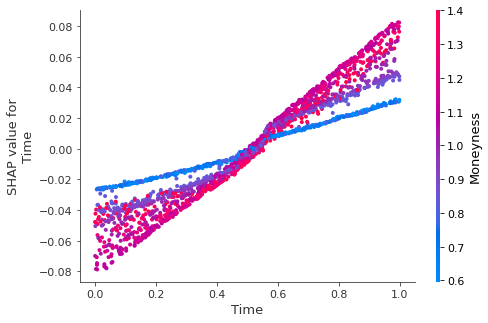

In [21]:
shap.dependence_plot(stg.TIME, shap_values, X_ref_shap)

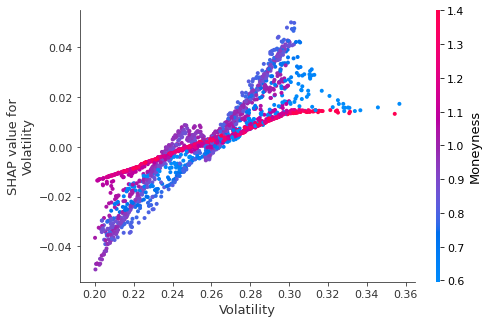

In [22]:
shap.dependence_plot(stg.VOLATILITY, shap_values, X_ref_shap)

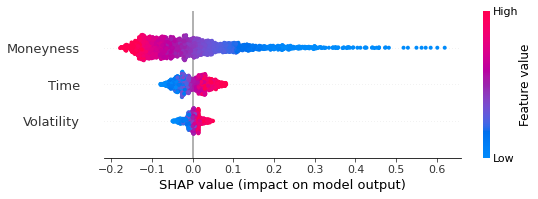

In [23]:
shap.summary_plot(shap_values, X_ref_shap, plot_type="dot")